# PsychoPy Analysis
The goal of this in-class activity is to understand how to read and analyze the data generated by PsychoPy experiments.

# Set Up

In [1]:
# Load necessary packages
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Set Directories

# get current directory
work_dir = os.getcwd()

# set data directory to be the data folder of the Motor_task
data_dir = os.path.join(os.path.dirname(work_dir), 'class_data/')

# Grab and organize data

In [3]:
# List data files
data_files = glob.glob(f'{data_dir}*.csv')
# print(data_files)

# Load one file
df = pd.read_csv(data_files[0])

# View columns
print(df.columns)

Index(['Trigger.started', 'Trigger.stopped', 'key_resp_4.keys',
       'key_resp_4.rt', 'key_resp_4.duration', 'mouse.x', 'mouse.y',
       'mouse.leftButton', 'mouse.midButton', 'mouse.rightButton', 'Session',
       'Subject', 'date', 'expName', 'psychopyVersion', 'OS', 'frameRate',
       'complex_block.started', 'complex_block.stopped', 'key_resp.keys',
       'key_resp.corr', 'key_resp.rt', 'key_resp.duration',
       'complex_block_loop.thisRepN', 'complex_block_loop.thisTrialN',
       'complex_block_loop.thisN', 'complex_block_loop.thisIndex',
       'complex_block_loop.ran', 'trial', 'finger', 'markerPos', 'correctResp',
       'new_block_loop.thisRepN', 'new_block_loop.thisTrialN',
       'new_block_loop.thisN', 'new_block_loop.thisIndex',
       'new_block_loop.ran', 'endBuffer.started', 'endBuffer.stopped'],
      dtype='object')


There are lots of unnecesary columns. Let's select just those we need

In [4]:
# Grab only desired columns for analysis
col_keep = ['finger','correctResp','key_resp.keys','key_resp.corr','key_resp.rt','complex_block_loop.thisRepN','new_block_loop.thisRepN']
df = df[col_keep]

# Loop over the other data files and read them all
for file_indx, file in enumerate(data_files):
    if file_indx > 0:
        data = pd.read_csv(file)
        if len(data) == 252: #only include complete runs of the experiment
            data = data[col_keep]
            df= pd.concat([df, data], ignore_index=True, axis=0)
df

,finger,correctResp,key_resp.keys,key_resp.corr,key_resp.rt,complex_block_loop.thisRepN,new_block_loop.thisRepN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M,2.0,2.0,1.0,0.6080,0.0,NaN
2,R,3.0,3.0,1.0,0.5530,0.0,NaN
3,M,2.0,2.0,1.0,0.6372,0.0,NaN
4,R,3.0,3.0,1.0,0.4611,0.0,NaN
...,...,...,...,...,...,...,...
6799,M,2.0,2.0,1.0,0.6660,NaN,4.0
6800,R,3.0,3.0,1.0,0.6413,NaN,4.0
6801,M,2.0,2.0,1.0,0.7063,NaN,4.0
6802,I,1.0,1.0,1.0,0.6320,NaN,4.0


# Plot Reaction Time Findings
One of the interesting measurements we can look at with this experiment is the reation time. We can look at different ways to analyse the reaction time. Below, we look at the average reaction time for each finger.

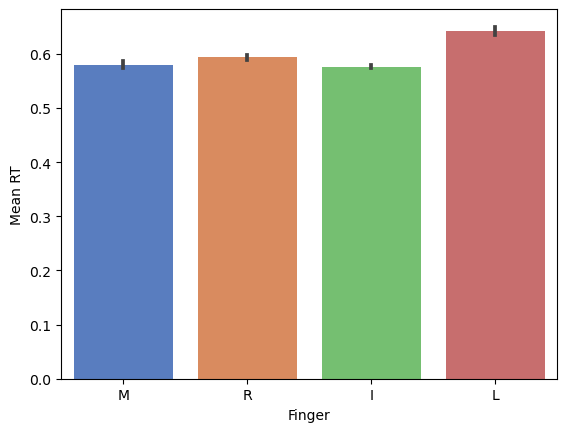

In [5]:
# Plot mean RT for each finger
sns.barplot(data=df, x='finger', y='key_resp.rt', errorbar='se', palette='muted')
plt.ylabel('Mean RT')
plt.xlabel('Finger')
plt.show()

We know from talking in class about implicit learning, that we expect reaction time to decrease throughout the course of the experiment because we "learn" the task as we go. We can lookat how reaction time changes over the course of the experiment.

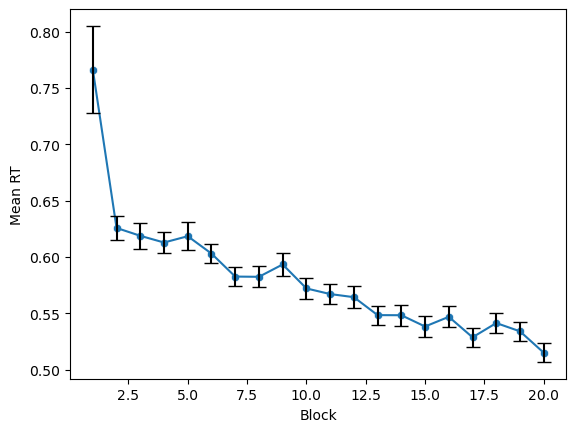

In [6]:
# Summarize RT by block
df_rt_block = df.groupby('complex_block_loop.thisRepN').agg(
    m_rt=('key_resp.rt', 'mean'),
    sd_rt=('key_resp.rt', 'std'),
    ntrial=('key_resp.rt', 'count')
).reset_index()

# Compute standard error
df_rt_block['se_rt'] = df_rt_block['sd_rt'] / np.sqrt(df_rt_block['ntrial'])

# Plot and add error bars
### note: add 1 to plot starting at 1 instead of 0
sns.lineplot(data=df_rt_block, x=df_rt_block['complex_block_loop.thisRepN'] + 1, y='m_rt')
sns.scatterplot(data=df_rt_block, x=df_rt_block['complex_block_loop.thisRepN'] + 1, y='m_rt')
plt.errorbar(x=df_rt_block['complex_block_loop.thisRepN'] + 1, y=df_rt_block['m_rt'], 
             yerr=df_rt_block['se_rt'], fmt='none', capsize=5, color='black')
plt.ylabel('Mean RT')
plt.xlabel('Block')
plt.show()

And now that we know the trick about this experiment if the use of a repeating sequence followed by a random sequence, we look at how reaction time changes specifically between the first set of blocks and the second set of blocks.

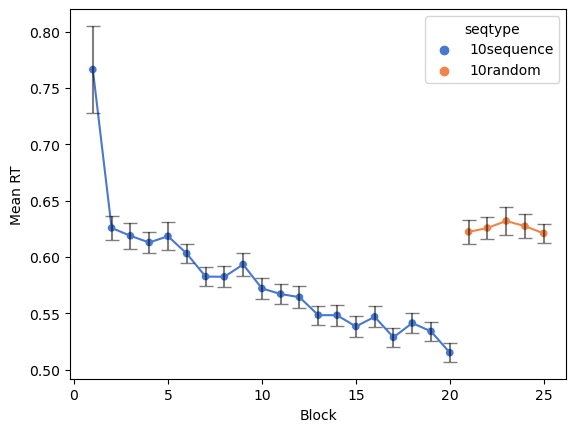

In [7]:
# New motor sequence started after 20 blocks
df['new_block_loop.thisRepN'] = df['new_block_loop.thisRepN'] + 20

# Creating a new variable for block number irrespective of block type
df['block'] = df[['complex_block_loop.thisRepN', 'new_block_loop.thisRepN']].sum(axis=1)

# Summarize RT by block
df_rt_block = df.groupby('block').agg(
    m_rt=('key_resp.rt', 'mean'),
    sd_rt=('key_resp.rt', 'std'),
    ntrial=('key_resp.rt', 'count')
).reset_index()

# Compute standard error
df_rt_block['se_rt'] = df_rt_block['sd_rt'] / np.sqrt(df_rt_block['ntrial'])

# Create categorical variable to denote repeated or random sequence
df_rt_block['seqtype'] = pd.Categorical(df_rt_block['block'] >= 20, categories=[False, True], ordered=True)

# Rename categories
df_rt_block['seqtype'] = df_rt_block['seqtype'].cat.rename_categories(['10sequence', '10random'])

# Plot
sns.lineplot(data=df_rt_block, x=df_rt_block['block'] + 1, y='m_rt', markers = True, hue='seqtype', palette='muted', legend=False)
sns.scatterplot(data=df_rt_block, x=df_rt_block['block'] + 1, y='m_rt', hue='seqtype', palette='muted', label='_nolegend_')
plt.errorbar(x=df_rt_block['block'] + 1, y=df_rt_block['m_rt'], 
             yerr=df_rt_block['se_rt'], fmt='none', capsize=5, color='black', alpha=.5)
plt.ylabel('Mean RT')
plt.xlabel('Block')
plt.show()

# Alternative Analyses
In addition to plotting reaction time, you can look at different ways to analyse and plot things like accuracy per block, accuracy per finger, accuracy per block type, etc. Be creative with your analyses and try something new!